In [1]:
import networkx as nx

In [2]:
H = nx.DiGraph()

In [3]:
#adding nodes
H.add_nodes_from([
  (0, {"color": "blue", "size": 250}),

  (1, {"color": "yellow", "size": 400}),

  (2, {"color": "orange", "size": 150}),

  (3, {"color": "red", "size": 600})


])

In [4]:
#adding edges
H.add_edges_from([
  (0, 1),

  (1, 2),

  (1, 0),

  (1, 3),

  (2, 3),

  (3,0)


])

In [5]:
node_colors = nx.get_node_attributes(H, "color").values()
colors = list(node_colors)
node_sizes = nx.get_node_attributes(H, "size").values()
sizes = list(node_sizes)

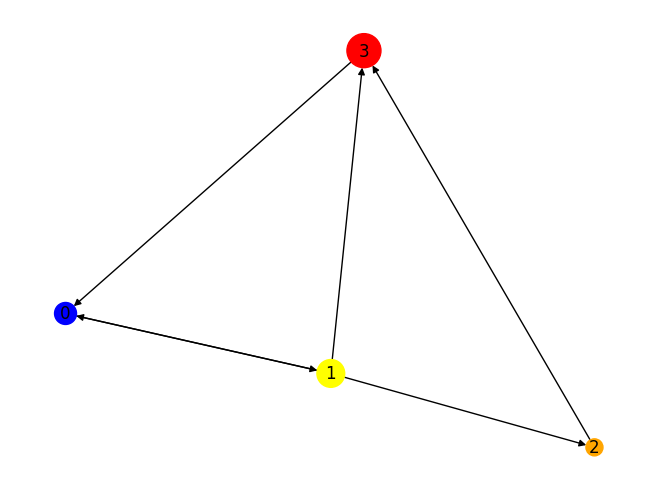

In [6]:
#Plotting Graph
nx.draw(H, with_labels=True, node_color=colors, node_size=sizes)

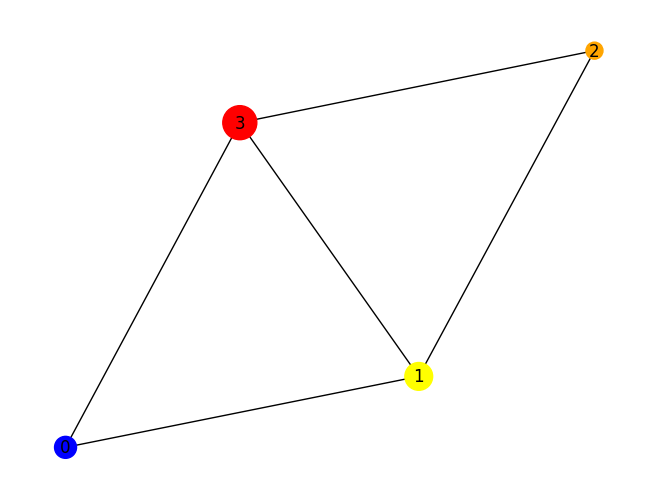

In [7]:
G = H.to_undirected()
nx.draw(G, with_labels=True, node_color=colors, node_size=sizes)

In [8]:
!pip install -q torch

In [9]:
%%capture
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [10]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)

Processing...


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!


## GCN

In [11]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

In [12]:
class GCN(torch.nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    torch.manual_seed(1234567)
    self.conv1 = GCNConv(dataset.num_features, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.conv2(x, edge_index)
    return x


In [13]:
model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

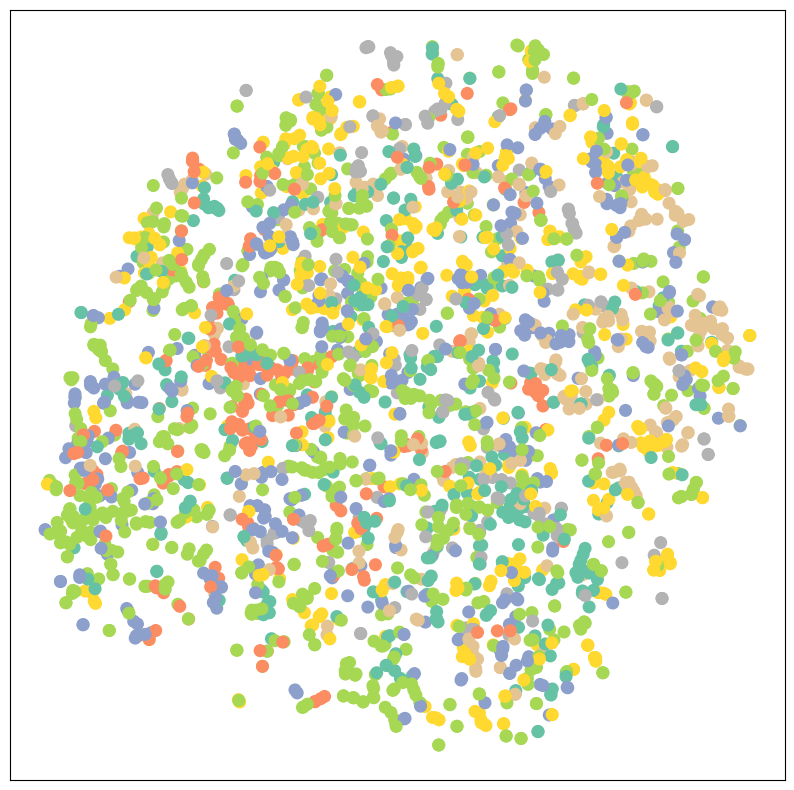

In [17]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [24]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [25]:
def train():
  model.train() # Включаем режим обучения (Dropout работает)
  optimizer.zero_grad() # Обнуляем градиенты с прошлого шага
  out = model(data.x, data.edge_index) # Прямой проход (Forward pass)
  loss = criterion(out[data.train_mask], data.y[data.train_mask]) # Считаем ошибку ТОЛЬКО на обучающих узлах (train_mask)
  loss.backward() # Обратное распространение (Backpropagation)
  optimizer.step() # Обновление весов (с учетом lr и weight_decay)
  return loss

In [26]:
def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc

In [27]:
for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9465
Epoch: 002, Loss: 1.9419
Epoch: 003, Loss: 1.9363
Epoch: 004, Loss: 1.9290
Epoch: 005, Loss: 1.9199
Epoch: 006, Loss: 1.9140
Epoch: 007, Loss: 1.9079
Epoch: 008, Loss: 1.8992
Epoch: 009, Loss: 1.8876
Epoch: 010, Loss: 1.8764
Epoch: 011, Loss: 1.8656
Epoch: 012, Loss: 1.8626
Epoch: 013, Loss: 1.8460
Epoch: 014, Loss: 1.8329
Epoch: 015, Loss: 1.8225
Epoch: 016, Loss: 1.8167
Epoch: 017, Loss: 1.7995
Epoch: 018, Loss: 1.7878
Epoch: 019, Loss: 1.7716
Epoch: 020, Loss: 1.7568
Epoch: 021, Loss: 1.7563
Epoch: 022, Loss: 1.7342
Epoch: 023, Loss: 1.7092
Epoch: 024, Loss: 1.7015
Epoch: 025, Loss: 1.6671
Epoch: 026, Loss: 1.6757
Epoch: 027, Loss: 1.6609
Epoch: 028, Loss: 1.6355
Epoch: 029, Loss: 1.6339
Epoch: 030, Loss: 1.6102
Epoch: 031, Loss: 1.5964
Epoch: 032, Loss: 1.5721
Epoch: 033, Loss: 1.5570
Epoch: 034, Loss: 1.5445
Epoch: 035, Loss: 1.5093
Epoch: 036, Loss: 1.4889
Epoch: 037, Loss: 1.4776
Epoch: 038, Loss: 1.4704
Epoch: 039, Loss: 1.4263
Epoch: 040, Loss: 1.3972


In [28]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8110


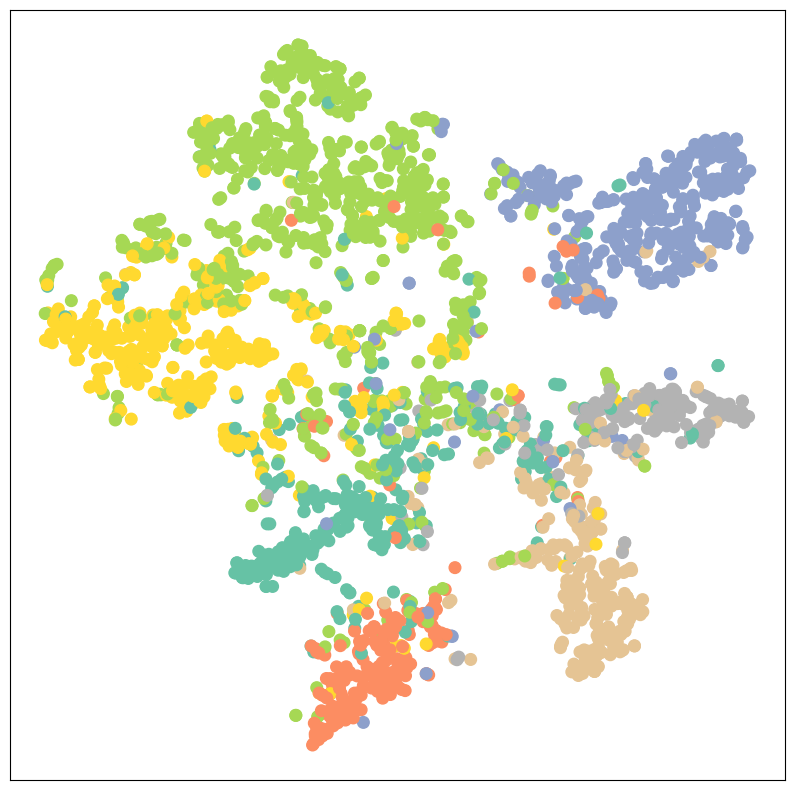

In [29]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## GATConv Model (Graph Attention Networks)

Uses masked self-attentional layers to address the drawbacks of GCNConv and achieve state-of-the-art results.

In [31]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
      super().__init__()
      torch.manual_seed(1234567)
      self.conv1 = GATConv(dataset.num_features, hidden_channels,heads)
      self.conv2 = GATConv(heads*hidden_channels, dataset.num_classes,heads)
    def forward(self, x, edge_index):
      x = F.dropout(x, p=0.6, training=self.training)
      x = self.conv1(x, edge_index)
      x = F.elu(x)
      x = F.dropout(x, p=0.6, training=self.training)
      x = self.conv2(x, edge_index)
      return x

In [40]:
model = GAT(hidden_channels=8, heads=8)
print(model)

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=8)
)


In [41]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [42]:
def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

In [43]:
def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      correct = pred[mask] == data.y[mask]
      acc = int(correct.sum()) / int(mask.sum())
      return acc

In [44]:
val_acc_all = []
test_acc_all = []

In [45]:
for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    val_acc_all.append(val_acc)
    test_acc_all.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 4.0245, Val: 0.1700, Test: 0.2040
Epoch: 002, Loss: 3.9922, Val: 0.2800, Test: 0.3010
Epoch: 003, Loss: 3.9547, Val: 0.3480, Test: 0.3720
Epoch: 004, Loss: 3.9151, Val: 0.3960, Test: 0.4480
Epoch: 005, Loss: 3.8637, Val: 0.4300, Test: 0.4750
Epoch: 006, Loss: 3.8053, Val: 0.4280, Test: 0.4850
Epoch: 007, Loss: 3.7579, Val: 0.4300, Test: 0.4770
Epoch: 008, Loss: 3.6782, Val: 0.4260, Test: 0.4620
Epoch: 009, Loss: 3.5984, Val: 0.4220, Test: 0.4410
Epoch: 010, Loss: 3.5145, Val: 0.4120, Test: 0.4250
Epoch: 011, Loss: 3.4376, Val: 0.3980, Test: 0.4030
Epoch: 012, Loss: 3.3417, Val: 0.3680, Test: 0.3890
Epoch: 013, Loss: 3.2471, Val: 0.3480, Test: 0.3700
Epoch: 014, Loss: 3.1213, Val: 0.3340, Test: 0.3580
Epoch: 015, Loss: 3.0203, Val: 0.3260, Test: 0.3410
Epoch: 016, Loss: 2.9081, Val: 0.3120, Test: 0.3220
Epoch: 017, Loss: 2.7991, Val: 0.2900, Test: 0.3040
Epoch: 018, Loss: 2.6981, Val: 0.2680, Test: 0.2830
Epoch: 019, Loss: 2.5645, Val: 0.2560, Test: 0.2690
Epoch: 020, 

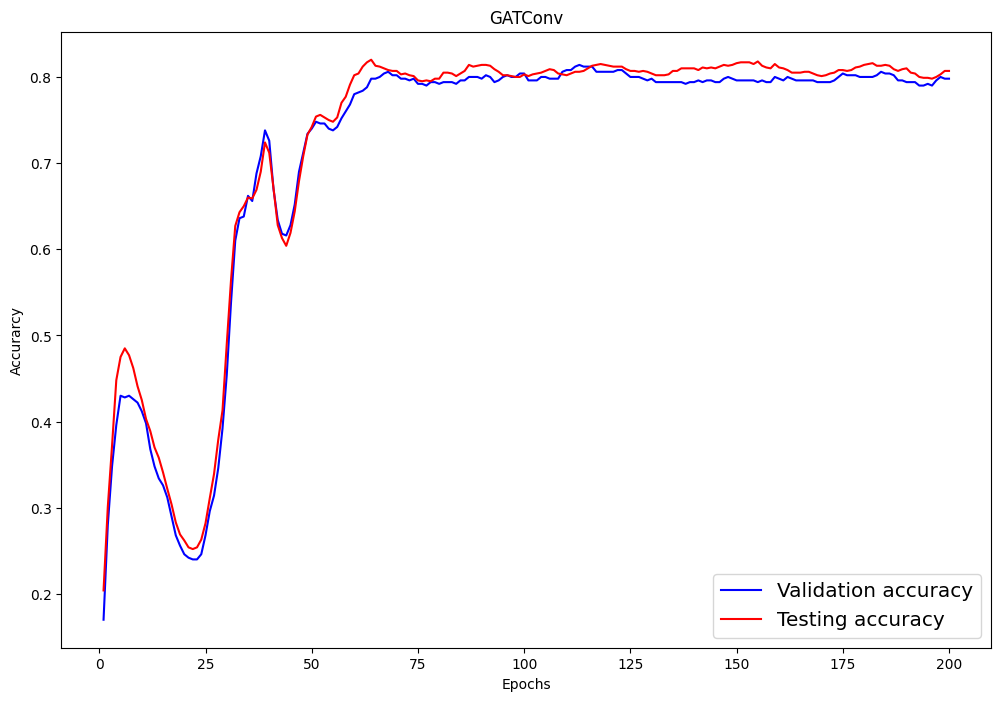

In [46]:
import numpy as np

plt.figure(figsize=(12,8))
plt.plot(np.arange(1, len(val_acc_all) + 1), val_acc_all, label='Validation accuracy', c='blue')
plt.plot(np.arange(1, len(test_acc_all) + 1), test_acc_all, label='Testing accuracy', c='red')
plt.xlabel('Epochs')
plt.ylabel('Accurarcy')
plt.title('GATConv')
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('gat_loss.png')
plt.show()

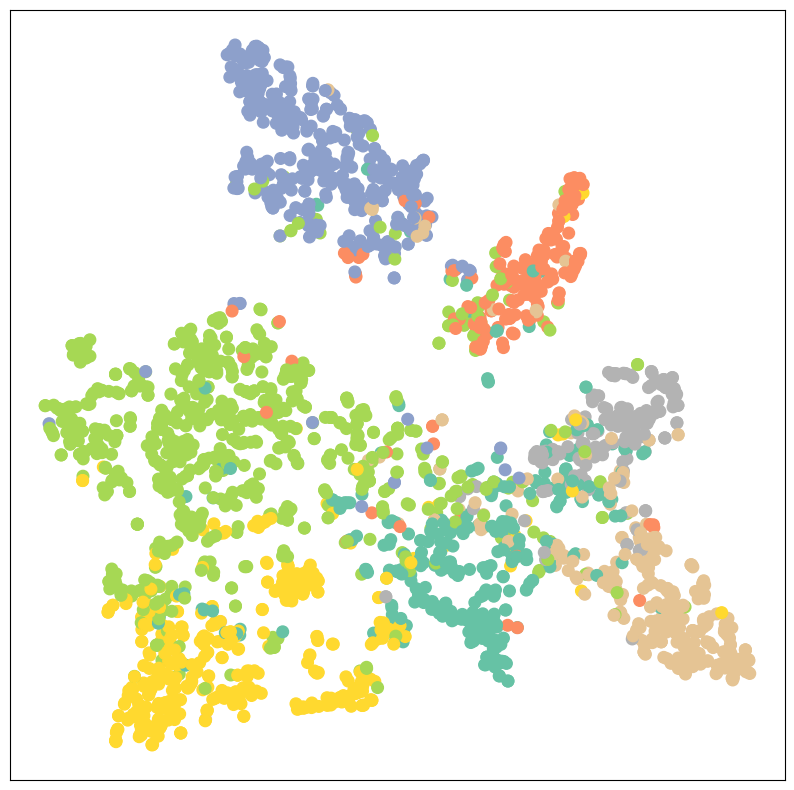

In [47]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)